In [2]:
import os
import glob
import qiime2 as q2
import pandas as pd
import itertools
from scipy.stats import ttest_ind
from qiime2.plugins.feature_table.methods import rarefy
from qiime2.plugins.longitudinal.pipelines import maturity_index

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline

In [3]:
body_site_data = {}
# body sites to explore
body_sites = {'fecal':'Baby-Feces',
              'oral':'Baby-Mouth',
              'skin':'Baby-Right_Forearm'}
# for each get the data 
time_ = 'date_sampling_category_days_continuous'
for bs, pth in body_sites.items():
    bt = q2.Artifact.load(os.path.join('../data/split-data',
                                       pth, 'table.qza'))
    #bt = rarefy(bt, 1200).rarefied_table
    mf = q2.Metadata.load(os.path.join('../data/split-data',
                                       pth, 'metadata.qza'))
    mf = mf.to_dataframe()
    mf['month'] = (mf[time_]//30).astype(int)
    mf['bimonthly'] = (mf[time_]//60).astype(int) * 2
    # save
    body_site_data[bs] = (bt, q2.Metadata(mf))


In [7]:
%%capture
# perams for MAZ
time_ = 'month'
group_by_ = 'birth_mode_ms'
control_ = 'Vag'
subjects_ = 'subjectid_unique'
rs_ = 42
jbs = 4
pt = True
ofs = False
stratify = True

maz_mf = {}
for bs, (bt, mf) in body_site_data.items():
    # get data
    bt, mf = body_site_data[bs]
    # run MAZ
    res = maturity_index(bt, mf, time_,
                         group_by_, control_,
                         random_state=rs_,
                         n_jobs=jbs,
                         parameter_tuning=pt,
                         optimize_feature_selection=ofs,
                         stratify=stratify)
    # save results
    for name_, art_ in res.__dict__.items():
        if name_ != '_fields':
            art_.save(os.path.join('../data/MAZ', bs, name_))
    # combine to plot
    mazdf = res.maz_scores.view(q2.Metadata).to_dataframe()
    mfmaz = mf.to_dataframe().copy()
    mazdf = mazdf.reindex(mfmaz.index)
    mfmaz['MAZ'] = mazdf[time_ + ' MAZ score'].values
    maz_mf[bs] = mfmaz


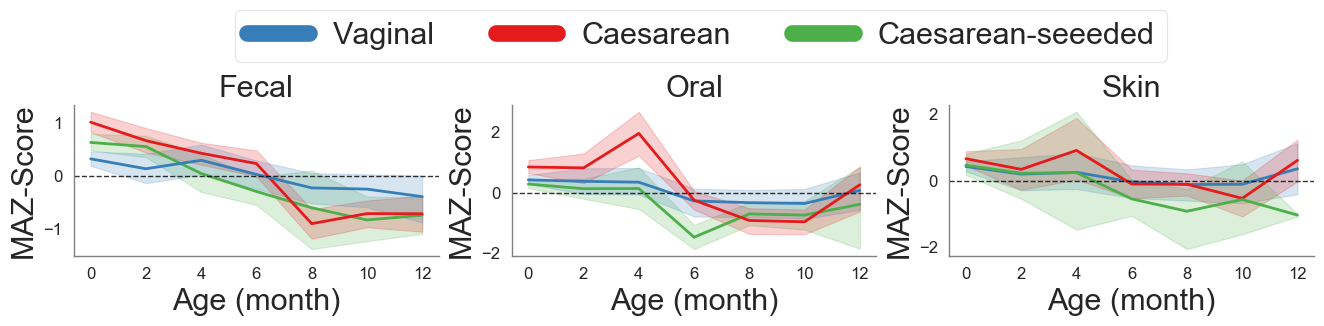

In [8]:
cmap_bm = {'CS':'#e41a1c',
           'CSseed':'#4daf4a',
           'Vag':'#377eb8'}
# for lack of samples
drop = {'fecal':[],'oral':[],'skin':[]}
tests = [('CSseed','Vag'),
         ('CS','Vag')]
t_tests_ = {}
time_ = 'bimonthly'
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': .1}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12

fig, axn = plt.subplots(1,3, figsize=(16, 2))

for ax, (bs_, mfmaz_plt) in zip(axn, maz_mf.items()):
    # remove time w/ no samples
    mfmaz_plt = mfmaz_plt.dropna(subset=['MAZ'])
    mfmaz_plt = mfmaz_plt[~mfmaz_plt.month.isin(drop[bs_])]
    # get stats
    for t_, t_mfmaz in mfmaz_plt.groupby(time_):
        for test_ in tests:
            tdf = pd.DataFrame(ttest_ind(t_mfmaz[t_mfmaz.birth_mode_ms.isin([test_[0]])].MAZ.values,
                                         t_mfmaz[t_mfmaz.birth_mode_ms.isin([test_[1]])].MAZ.values)).T
            t_tests_[(' vs. '.join(test_), bs_, t_)] = tdf
    # plot the MAZ scores
    sns.lineplot(y='MAZ',x=time_,
                  hue=group_by_,
                  data=mfmaz_plt,
                  palette=cmap_bm,
                  ax=ax, ci=95)
    ax.set_title(bs_.capitalize(),
                 fontsize=22)
    ax.set_ylabel('MAZ-Score',
                  fontsize=22)
    ax.set_xlabel('Age (month)',
                  fontsize=22)
    ax.axhline(0, ls='--', lw=1,
               color='black', alpha=.8)
    # fix backround
    ax.legend_.remove()
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

# generate legend from last iterations  
fix_labels = {'Vag':'Vaginal', 'CS':'Caesarean', 'CSseed':'Caesarean-seeeded'}
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:],
                   [fix_labels[l] for l in labels[1:]],
                   loc=2, 
                   bbox_to_anchor=(-2.0, 1.73),
                   prop={'size':22},
                   fancybox=True, framealpha=0.5, 
                   ncol=3, markerscale=2.5,
                   facecolor="white")
#"""
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(12.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(12.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)
# save fig
plt.savefig('../results/Extended-Data-Figure-4.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [9]:
t_tests_df = pd.concat(t_tests_).dropna()
t_tests_df.columns = ['T','P']
# correction
t_tests_df['P'] = t_tests_df.P * 3
#t_tests_df.to_csv('../results/MAZ-stats.tsv', sep='\t')
t_tests_df.head(5)


,,,,T,P
CSseed vs. Vag,fecal,0.0,0,2.847222,1.382677e-02
CS vs. Vag,fecal,0.0,0,5.805668,4.125413e-08
CSseed vs. Vag,fecal,2.0,0,2.407723,5.264949e-02
CS vs. Vag,fecal,2.0,0,2.895493,1.355509e-02
CSseed vs. Vag,fecal,4.0,0,-1.082428,8.477315e-01


In [10]:
t_tests_df[t_tests_df.P < 0.05].to_csv('../results/Extended-Data-Table-5.tsv', sep='\t')
t_tests_df[t_tests_df.P < 0.05]

T             P
CSseed vs. Vag fecal 0.0 0  2.847222  1.382677e-02
CS vs. Vag     fecal 0.0 0  5.805668  4.125413e-08
                     2.0 0  2.895493  1.355509e-02
                     8.0 0 -3.076441  8.349909e-03
               oral  0.0 0  3.303288  3.209071e-03
                     4.0 0  3.065413  1.112127e-02
CSseed vs. Vag oral  6.0 0 -3.790294  1.955848e-03